### -ML PROJECT-

-Load Data

In [1]:
! pip install datasets -q
from datasets import load_dataset

DATASET_ID = "ag_news"
ds = load_dataset(DATASET_ID)

train_data = ds['train']
test_data = ds['test']

print("✅ Dataset 'ag_news' loaded successfully into 'ds', 'train_data', and 'test_data'.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset 'ag_news' loaded successfully into 'ds', 'train_data', and 'test_data'.


-Text Preprocessing

In [2]:
import pandas as pd
import re
import string

train_data = train_data.to_pandas()
test_data = test_data.to_pandas()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

print("Applying text cleaning function to training and testing data...")

train_data['text'] = train_data['text'].apply(clean_text)

test_data['text'] = test_data['text'].apply(clean_text)

print("Text cleaning complete.")

Applying text cleaning function to training and testing data...
Text cleaning complete.


-EDA

In [3]:
#Data Shape
print("Dataset Structure:")
print(ds)


print(f"Number of rows (examples): {len(train_data)}")
print(f"Number of columns (features): {train_data.shape[1]}")
print(f"Column names: {list(train_data.columns)}")

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
Number of rows (examples): 120000
Number of columns (features): 2
Column names: ['text', 'label']



Label Distribution in Training Set:
label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64


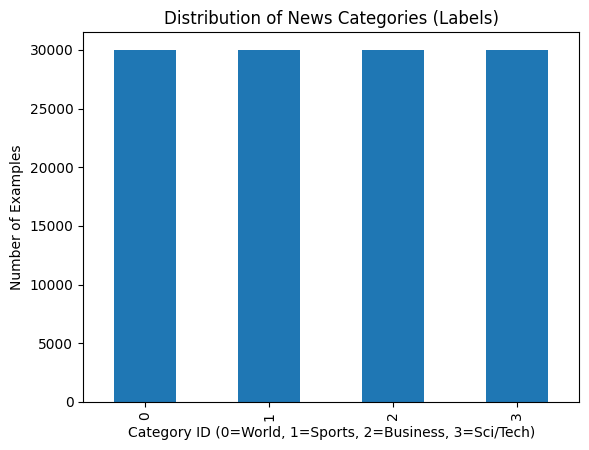

In [4]:
#Lable distribution
import pandas as pd
import matplotlib.pyplot as plt

labels = pd.Series(train_data['label'])
label_counts = labels.value_counts().sort_index()

print("\nLabel Distribution in Training Set:")
print(label_counts)

label_counts.plot(kind='bar')
plt.title('Distribution of News Categories (Labels)')
plt.xlabel('Category ID (0=World, 1=Sports, 2=Business, 3=Sci/Tech)')
plt.ylabel('Number of Examples')
plt.show()


Text Length Statistics (in words):
count    120000.000000
mean         37.416092
std           9.891889
min           8.000000
25%          31.000000
50%          37.000000
75%          42.000000
max         177.000000
Name: text_length, dtype: float64


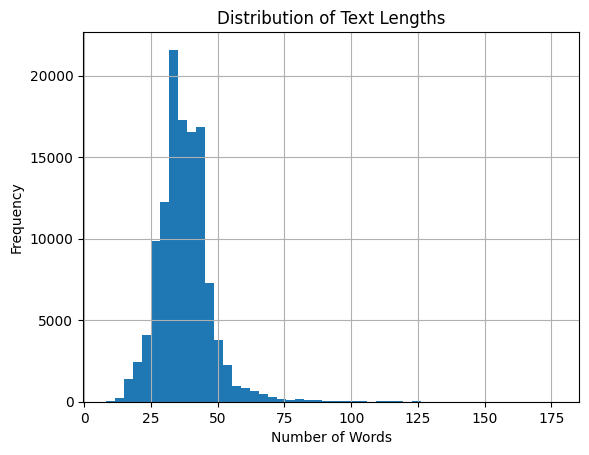

In [5]:
#Text length analysis
train_data_df = pd.DataFrame(train_data)
train_data_df['text_length'] = train_data_df['text'].apply(lambda x: len(x.split()))

print("\nText Length Statistics (in words):")
print(train_data_df['text_length'].describe())

train_data_df['text_length'].hist(bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

-Data Preprocessing

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Training Set
X_train_text = train_data['text']  # Text is the Feature
y_train_label = train_data['label'] # Label is the Target

# Test Set
X_test_text = test_data['text']
y_test_label = test_data['label']

print("1. Successfully separated X (text) and y (labels) for training and testing sets.")

# ApplyTF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_features = vectorizer.fit_transform(X_train_text)

X_test_features = vectorizer.transform(X_test_text)

print("2. Text successfully converted to TF-IDF numerical features.")
print(f"   Training features shape: {X_train_features.shape}")
print(f"   Testing features shape: {X_test_features.shape}")

1. Successfully separated X (text) and y (labels) for training and testing sets.
2. Text successfully converted to TF-IDF numerical features.
   Training features shape: (120000, 5000)
   Testing features shape: (7600, 5000)


-Model  Implementation

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import time

#1.Logistic Regression
print("--- 1. Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
start_time_lr = time.time()
lr_model.fit(X_train_features, y_train_label)
print(f"   Training Time: {time.time() - start_time_lr:.2f} seconds.")

#2.K-Nearest Neighbors (KNN)
print("\n--- 2. Training K-Nearest Neighbors (KNN) ---")
# k=5
knn_model = KNeighborsClassifier(n_neighbors=5)
start_time_knn = time.time()
knn_model.fit(X_train_features, y_train_label)
print(f"   Training Time: {time.time() - start_time_knn:.2f} seconds.")

#3.Support Vector Machine (SVM)
print("\n--- 3. Training Support Vector Machine (SVM) ---")
svm_model = LinearSVC(random_state=42, max_iter=1000)
start_time_svm = time.time()
svm_model.fit(X_train_features, y_train_label)
print(f"   Training Time: {time.time() - start_time_svm:.2f} seconds.")

print("\n✅ Training complete for all three models.")

--- 1. Training Logistic Regression ---
   Training Time: 13.13 seconds.

--- 2. Training K-Nearest Neighbors (KNN) ---
   Training Time: 0.03 seconds.

--- 3. Training Support Vector Machine (SVM) ---
   Training Time: 6.89 seconds.

✅ Training complete for all three models.


-Evaluation

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

lr_predictions = lr_model.predict(X_test_features)
knn_predictions = knn_model.predict(X_test_features)
svm_predictions = svm_model.predict(X_test_features)

target_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# 1. Logistic Regression Report
print("\n--- Evaluation Report: Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test_label, lr_predictions):.4f}")
print("\nClassification Report:\n", classification_report(y_test_label, lr_predictions, target_names=target_names))

# 2. K-Nearest Neighbors (KNN) Report
print("\n--- Evaluation Report: K-Nearest Neighbors (KNN) ---")
print(f"Accuracy: {accuracy_score(y_test_label, knn_predictions):.4f}")
print("\nClassification Report:\n", classification_report(y_test_label, knn_predictions, target_names=target_names))

# 3. Support Vector Machine (SVM) Report
print("\n--- Evaluation Report: Support Vector Machine (SVM) ---")
print(f"Accuracy: {accuracy_score(y_test_label, svm_predictions):.4f}")
print("\nClassification Report:\n", classification_report(y_test_label, svm_predictions, target_names=target_names))


--- Evaluation Report: Logistic Regression ---
Accuracy: 0.9039

Classification Report:
               precision    recall  f1-score   support

       World       0.92      0.90      0.91      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.87      0.87      0.87      1900
    Sci/Tech       0.88      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


--- Evaluation Report: K-Nearest Neighbors (KNN) ---
Accuracy: 0.8843

Classification Report:
               precision    recall  f1-score   support

       World       0.90      0.88      0.89      1900
      Sports       0.90      0.96      0.93      1900
    Business       0.87      0.84      0.86      1900
    Sci/Tech       0.86      0.86      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600

-Label Distribution

/tmp/ipython-input-141768199.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_series_named, palette='viridis')


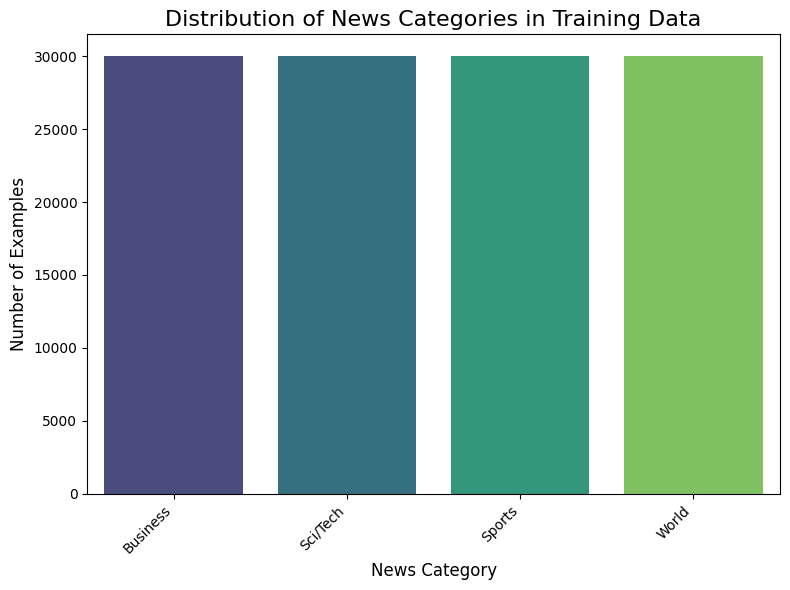

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

labels_series = pd.Series(y_train_label)

category_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
labels_series_named = labels_series.map(category_names)

plt.figure(figsize=(8, 6))
sns.countplot(x=labels_series_named, palette='viridis')
plt.title('Distribution of News Categories in Training Data', fontsize=16)
plt.xlabel('News Category', fontsize=12)
plt.ylabel('Number of Examples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()